<center><h1>Get Data on NHS Waiting Times</h1></center>

<h3>Get urls of all pages with the data</h3>

In [3]:
import requests, sys, webbrowser, bs4, os
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
from time import strptime
import matplotlib
import csv
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

printOutput = False

os.makedirs('AnE_Data', exist_ok=True)

root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")
page_names = []

for elem in linkElems:
    if "Monthly A&E Attendances and Emergency Admissions" in elem.getText():
        page_names.append(elem.get('href'))
    elif "Weekly A&E Attendances and Emergency Admissions" in elem.getText():
        page_names.append(elem.get('href'))

print("Total of {} pages found".format(len(page_names)))

Total of 12 pages found


<h2>Get all csv and xls file names</h2>

In [4]:
csv_file_names = []
xls_file_names = []

for name in page_names:
    #print("Looking at page: ", name, '\n')
    res = requests.get(name)
    soup = bs4.BeautifulSoup(res.content)
    linkElems = soup.select("a")
    for elem in linkElems:
        if '.csv' in elem.get('href'):
            csv_file_names.append(elem.get('href'))
        # Take out quarters because they're difficult to deal with.
        elif 'AE' in elem.get('href') and '.xls' in elem.get('href'):
            xls_file_names.append(elem.get('href'))
            #print(elem.get('href'))
        elif 'by-provider' in elem.get('href') and '.xls' in elem.get('href'):
            # To account for the change in January 2020
            xls_file_names.append(elem.get('href'))
print("Total of {} csv files and {} xls files.".format(len(csv_file_names), len(xls_file_names)))

Total of 32 csv files and 347 xls files.


In [5]:
for file in xls_file_names[190:200]:
    resp = requests.get(file)

<h2>Take data from xls files</h2>

In [6]:
attendence_months = []
over4hours_months = []
period_months = []

attendence_weeks = []
over4hours_weeks = []
period_weeks = []

month_names = ["January", "February","March", "April","May", "June", "July",
          "August", "September", "October", "November", "December"]

def try1(sheet):
    try: over4hours = sheet["Total Attendances > 4 hours"][0]
    except: return False 
    return True

def try2(sheet):
    try: over4hours = sheet["Total Attendances < 4 hours"][0]
    except: return False 
    return True

def try3(sheet):
    try: over4hours = sheet["Percentage in 4 hours or less (all)"][0]
    except: return False 
    return True

def makeDataMask(data):
    dataMask = np.zeros(len(data),dtype=bool)
    for c, cell in enumerate(data):
        if type(cell)==str or np.isnan(cell):
            dataMask[c]=False
        else:
            dataMask[c]=True
    return dataMask

# Make vectorised int function
vecint = np.vectorize(int)

avoid_list = ["Quarter", "QUARTER", "Timeseries","Time-Series", "Q1","Q2","Q3","Q4","transparency"]

def check_file(name):
    '''Checks if the file name contains any of the words from avoid_list
    which indicate that the file is not one of the normal monthly datasets.
    
    Returns single Boolean.
    '''
    use = True
    for item in avoid_list:
        if item in name:
            use = False
    return use 

# Gather data that we actually want to use
data = []
for i, name in enumerate(xls_file_names):
    if check_file(name):
        data.append(name)
              
print("Found {} data sets.".format(len(data)))

Found 292 data sets.


In [7]:
############################################################################################
########################## Get names and initiate data storage #############################
############################################################################################

resp = requests.get(data[0])
# Store the data in a temporary file
tempfile = open('tempfile.xls', 'wb')
tempfile.write(resp.content)
tempfile.close()
sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=15, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N")
#allNames = np.load("AllNames.npy", allow_pickle=True) #sheet['Name'].values    

# This should be saved externally (or make this script a module)
allNames = np.array(["England", np.nan, "Bedfordshire Hospitals NHS Foundation Trust", "Cambridge University Hospitals NHS Foundation Trust", "Clacton Hospital", "East And North Hertfordshire NHS Trust", "East Suffolk And North Essex NHS Foundation Trust", "Fryatt Hospital", "Hertfordshire Community NHS Trust", "Herts Urgent Care (Ascots Lane)", "James Paget University Hospitals NHS Foundation Trust", "Mid And South Essex NHS Foundation Trust", "Milton Keynes University Hospital NHS Foundation Trust", "Norfolk And Norwich University Hospitals NHS Foundation Trust", "North West Anglia NHS Foundation Trust", "Putnoe Medical Centre Walk In Centre", "The Princess Alexandra Hospital NHS Trust", "The Queen Elizabeth Hospital, King's Lynn, NHS Foundation Trust", "West Hertfordshire Hospitals NHS Trust", "West Suffolk NHS Foundation Trust", "Barking, Havering And Redbridge University Hospitals NHS Trust", "Barts Health NHS Trust", "Beckenham Beacon Ucc", "Central London Community Healthcare NHS Trust", "Chelsea And Westminster Hospital NHS Foundation Trust", "Croydon Health Services NHS Trust", "Epsom And St Helier University Hospitals NHS Trust", "Guy's And St Thomas' NHS Foundation Trust", "Hhcic East Wic", "Homerton University Hospital NHS Foundation Trust", "Hounslow And Richmond Community Healthcare NHS Trust", "Imperial College Healthcare NHS Trust", "King's College Hospital NHS Foundation Trust", "Kingston Hospital NHS Foundation Trust", "Lewisham And Greenwich NHS Trust", "London North West University Healthcare NHS Trust", "Moorfields Eye Hospital NHS Foundation Trust", "North East London NHS Foundation Trust", "North Middlesex University Hospital NHS Trust", "Royal Brompton & Harefield NHS Foundation Trust", "Royal Free London NHS Foundation Trust", "Royal National Orthopaedic Hospital NHS Trust", "St George's University Hospitals NHS Foundation Trust", "The Hillingdon Hospitals NHS Foundation Trust", "The Pinn Unregistered Wic", "University College London Hospitals NHS Foundation Trust", "Urgent Care Centre (Qms)", "Whittington Health NHS Trust", "Assura Vertis Urgent Care Centres (Birmingham)", "Badger Ltd", "Birmingham Wic", "Birmingham Women's And Children's NHS Foundation Trust", "Chesterfield Royal Hospital NHS Foundation Trust", "Corby Urgent Care Centre", "Coventry And Warwickshire Partnership NHS Trust", "Derbyshire Community Health Services NHS Foundation Trust", "Dhu Health Care C.I.C", "Erdington GP Health & Wellbeing Wic", "George Eliot Hospital NHS Trust", "Kettering General Hospital NHS Foundation Trust", "Latham House Medical Practice", "Lincolnshire Community Health Services NHS Trust", "Llr Ea - The Merlyn Vaz Health & Social Care Centre", "Loughborough Urgent Care Centre", "Market Harborough", "Market Harborough Med.Ctr", "Melton Mowbray", "Northampton General Hospital NHS Trust", "Nottingham Citycare Partnership", "Nottingham University Hospitals NHS Trust", "Oadby", "Oakham", "Oakham Medical Practice", "Sandwell And West Birmingham Hospitals NHS Trust", "Sherwood Forest Hospitals NHS Foundation Trust", "Shrewsbury And Telford Hospital NHS Trust", "Shropshire Community Health NHS Trust", "Sleaford Medical Group", "South Birmingham GP Walk In Centre", "South Warwickshire NHS Foundation Trust", "Summerfield GP Surg & Urgent Care Centre", "The Dudley Group NHS Foundation Trust", "The Robert Jones And Agnes Hunt Orthopaedic Hospital NHS Foundation Trust", "The Royal Wolverhampton NHS Trust", "United Lincolnshire Hospitals NHS Trust", "University Hospitals Birmingham NHS Foundation Trust", "University Hospitals Coventry And Warwickshire NHS Trust", "University Hospitals Of Derby And Burton NHS Foundation Trust", "University Hospitals Of Leicester NHS Trust", "University Hospitals Of North Midlands NHS Trust", "Walsall Healthcare NHS Trust", "Worcestershire Acute Hospitals NHS Trust", "Wye Valley NHS Trust", "Airedale NHS Foundation Trust", "Barnsley Hospital NHS Foundation Trust", "Bradford Teaching Hospitals NHS Foundation Trust", "Bransholme Health Centre", "Calderdale And Huddersfield NHS Foundation Trust", "County Durham And Darlington NHS Foundation Trust", "Doncaster And Bassetlaw Teaching Hospitals NHS Foundation Trust", "East Riding Community Hospital", "Gateshead Health NHS Foundation Trust", "Goole & District Hospital", "Harrogate And District NHS Foundation Trust", "Hull University Teaching Hospitals NHS Trust", "Humber Teaching NHS Foundation Trust", "Leeds Teaching Hospitals NHS Trust", "Local Care Direct", "Mid Yorkshire Hospitals NHS Trust", "North Cumbria Integrated Care NHS Foundation Trust", "North Tees And Hartlepool NHS Foundation Trust", "Northern Lincolnshire And Goole NHS Foundation Trust", "Northumbria Healthcare NHS Foundation Trust", "Park Community Practice", "Sheffield Children's NHS Foundation Trust", "Sheffield Teaching Hospitals NHS Foundation Trust", "South Tees Hospitals NHS Foundation Trust", "South Tyneside And Sunderland NHS Foundation Trust", "South West Yorkshire Partnership NHS Foundation Trust", "St.George's Centre", "The Newcastle Upon Tyne Hospitals NHS Foundation Trust", "The Rotherham NHS Foundation Trust", "The Wilberforce Health Centre", "Workington Health Limited", "York Teaching Hospital NHS Foundation Trust", "Alder Hey Children's NHS Foundation Trust", "Blackpool Teaching Hospitals NHS Foundation Trust", "Bolton NHS Foundation Trust", "Bridgewater Community Healthcare NHS Foundation Trust", "Countess Of Chester Hospital NHS Foundation Trust", "East Cheshire NHS Trust", "East Lancashire Hospitals NHS Trust", "Lancashire Teaching Hospitals NHS Foundation Trust", "Liverpool Heart And Chest Hospital NHS Foundation Trust", "Liverpool University Hospitals NHS Foundation Trust", "Liverpool Women's NHS Foundation Trust", "Manchester University NHS Foundation Trust", "Mersey Care NHS Foundation Trust", "Mid Cheshire Hospitals NHS Foundation Trust", "Miriam Minor Emergency", "North West Boroughs Healthcare NHS Foundation Trust", "Pennine Acute Hospitals NHS Trust", "Rossendale Minor Injuries Unit", "Salford Royal NHS Foundation Trust", "Skelmersdale Walk In Centre", "Southport And Ormskirk Hospital NHS Trust", "St Helens And Knowsley Teaching Hospitals NHS Trust", "Stockport NHS Foundation Trust", "Tameside And Glossop Integrated Care NHS Foundation Trust", "The Christie NHS Foundation Trust", "The Walton Centre NHS Foundation Trust", "University Hospitals Of Morecambe Bay NHS Foundation Trust", "Warrington And Halton Teaching Hospitals NHS Foundation Trust", "Wirral Community Health And Care NHS Foundation Trust", "Wirral University Teaching Hospital NHS Foundation Trust", "Wrightington, Wigan And Leigh NHS Foundation Trust", "Ashford And St Peter's Hospitals NHS Foundation Trust", "Ashford Walk-In-Centre", "Assura Reading Llp", "Berkshire Healthcare NHS Foundation Trust", "Bracknell Urgent Care Centre Wic", "Brighton And Sussex University Hospitals NHS Trust", "Brighton Station Health Centre", "Buckinghamshire Healthcare NHS Trust", "Dartford And Gravesham NHS Trust", "East Berks Primary Care Ooh(Wam)", "East Kent Hospitals University NHS Foundation Trust", "East Sussex Healthcare NHS Trust", "Eastbourne Station Health Centre", "First Community Health And Care Cic", "Frimley Health NHS Foundation Trust", "Hampshire Hospitals NHS Foundation Trust", "Haslemere Minor Injuries Unit", "Hastings Med P & Walkin", "Isle Of Wight NHS Trust", "Kent Community Health NHS Foundation Trust", "Maidstone And Tunbridge Wells NHS Trust", "Medway NHS Foundation Trust", "Oxford Health NHS Foundation Trust", "Oxford University Hospitals NHS Foundation Trust", "Phl Lymington Utc", "Portsmouth Hospitals University National Health Service Trust", "Queen Victoria Hospital NHS Foundation Trust", "Royal Berkshire NHS Foundation Trust", "Royal Surrey County Hospital NHS Foundation Trust", "Southampton NHS Treatment Centre", "Southern Health NHS Foundation Trust", "St Mary's NHS Treatment Centre", "Surrey And Sussex Healthcare NHS Trust", "Sussex Community NHS Foundation Trust", "University Hospital Southampton NHS Foundation Trust", "Western Sussex Hospitals NHS Foundation Trust", "Whitstable Medical Practice", "Woking Walk In Centre", "Cornwall Partnership NHS Foundation Trust", "Dorset County Hospital NHS Foundation Trust", "Dorset Healthcare University NHS Foundation Trust", "Exmouth Minor Injury Unit", "Gloucestershire Health And Care NHS Foundation Trust", "Gloucestershire Hospitals NHS Foundation Trust", "Great Western Hospitals NHS Foundation Trust", "North Bristol NHS Trust", "Northern Devon Healthcare NHS Trust", "Okehampton Medical Centre", "Paulton Memorial Hospital", "Poole Hospital NHS Foundation Trust", "Royal Cornwall Hospitals NHS Trust", "Royal Devon And Exeter NHS Foundation Trust", "Royal United Hospitals Bath NHS Foundation Trust", "Salisbury NHS Foundation Trust", "Sirona Care & Health", "Somerset NHS Foundation Trust", "Tetbury Hospital Trust Ltd", "The Royal Bournemouth And Christchurch Hospitals NHS Foundation Trust", "Torbay And South Devon NHS Foundation Trust", "University Hospitals Bristol And Weston NHS Foundation Trust", "University Hospitals Plymouth NHS Trust", "Wiltshire Health & Care", "Yeovil District Hospital NHS Foundation Trust"], dtype=object)

oldTrusts = np.array(["Bedford Hospital NHS Trust", 
                      "Luton And Dunstable University Hospital NHS Foundation Trust",
                      "Basildon And Thurrock University Hospitals NHS Foundation Trust",
                      "Mid Essex Hospital Services NHS Trust",
                      "Southend University Hospital NHS Foundation Trust",
                      "Royal Liverpool And Broadgreen University Hospitals NHS Trust",
                      "Aintree University Hospital NHS Foundation Trust",
                      "Central Manchester University Hospitals NHS Foundation Trust",
                      "University Hospital Of South Manchester NHS Foundation Trust"])

allNames = np.concatenate((allNames, oldTrusts))

attendences2 = np.zeros((len(allNames), len(data)),dtype=object) 
attendences2[:,:] = '-'
over4hours = np.zeros((len(allNames), len(data)),dtype=object) 
over4hours[:,:] = '-'

periods2 = np.zeros(len(data),dtype = object)

In [8]:
############################################################################################
############################### Add data for each data set #################################
############################################################################################
    
missing = []
    
for i, name in enumerate(data):   
    # Get the data location
    resp = requests.get(name)

    # Store the data in a temporary file
    tempfile = open('tempfile.xls', 'wb')
    tempfile.write(resp.content)
    tempfile.close()

    # Get all of the data from row 16 with columns A to N
    # I don't think this is how try is supposed to be used but it works
    sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=15, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N")
    sheetTest = sheet

    names = sheet['Name'].values  
    all_attendence = sheet["Total attendances"]
    
    # Get the total attendance
    try:
        attendence = sheet["Total attendances"][0]
    except:
        attendence = sheet["Total Attendances"][0]
    
    
    # Try each of the three attendance column headers
    if try1(sheet):
        #print(1)
        sample = sheet["Total Attendances > 4 hours"].values
        all_over4hours = np.zeros(len(sample),dtype=object)
        all_over4hours[:] = '-'
        mask = makeDataMask(sample)
        all_over4hours[mask] = sample[mask]
    elif try2(sheet):
        #print(2)
        sample = sheet["Total Attendances < 4 hours"].values
        all_over4hours = np.zeros(len(sample),dtype=object)
        all_over4hours[:] = '-'
        mask = makeDataMask(sample)
        all_over4hours[mask] = all_attendence.values[mask] - sample[mask]
    elif try3(sheet):
        #print(3)
        sample = sheet["Percentage in 4 hours or less (all)"].values
        all_over4hours = np.zeros(len(sample),dtype=object)
        all_over4hours[:] = '-'
        mask = makeDataMask(sample)
        all_over4hours[mask] = vecint((1-sample[mask])*all_attendence.values[mask])
        
    for j, fname in enumerate(allNames):
        if fname in names:
            # Save attendance data
            hospital_attendence = all_attendence[names==fname]
            attendences2[:,i][allNames==fname] = hospital_attendence
            
            # Save waiting data
            num_waiting = all_over4hours[names==fname]
            over4hours[:,i][allNames==fname] = num_waiting
        
        # Combine Luton + Dunst Hosp with Luton + Dunst *Uni* Hosp
        if "Luton And Dunstable Hospital NHS Foundation Trust" in names:
            hospital_attendence = all_attendence[names=="Luton And Dunstable Hospital NHS Foundation Trust"]
            attendences2[:,i][allNames=="Luton And Dunstable University Hospital NHS Foundation Trust"] = hospital_attendence
            
            # Save waiting data
            num_waiting = all_over4hours[names=="Luton And Dunstable Hospital NHS Foundation Trust"]
            over4hours[:,i][allNames=="Luton And Dunstable University Hospital NHS Foundation Trust"] = num_waiting
            
        else:
            #print("Error: {} not found".format(fname))
            pass
        
    # checking for missing names
    for test_name in names:
        if test_name not in allNames and test_name not in missing:
            #print("Error: {} has no home".format(test_name))
            missing.append(test_name)
            
    # Get cell containing the data period
    sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="C")
    period = sheet.columns[0]
    #print(period)
    periods2[i] = period

    if printOutput == False:
        print("{} complete of {}...".format(i+1,len(data)),end = "\r")

<h2>Turn weekly data into monthly data</h2>

In [9]:
month_names = ["January", "February","March", "April","May", "June", "July",
          "August", "September", "October", "November", "December"]

def convMonths(date):
    strip=strptime(date, "%B %Y")
    text = "{:02d}/{}".format(strip[1], strip[0])
    return text

def convPeriods(periods):
    # Make array of monthly data periods
    
    period_months = []
    for period in periods:
        # Check if it's month or week data
        month = False
        if period.split(' ')[0] in month_names:
            text = convMonths(period)
            period_months.append(text)
        else:
            text = period.split(' ')[2][3:]
            if text not in period_months:
                period_months.append(text)
    return period_months

def weekly2monthy(dates, weekly_data, printOutput = False):
    # It's "Week ending <date>" so for each week, if the day is less than 7 
    # I need to give a fraction to the previous month
    days = np.zeros(len(dates))
    months = np.zeros(len(dates))
    years = np.zeros(len(dates))
    
    for i,week in enumerate(dates):
        #print(week)
        split = week.split(' ')[2].split('/')
        days[i] = int(split[0])
        months[i] = int(split[1])
        years[i] = int(split[2])

    monthly_data = []
    weekly_data = np.asarray(weekly_data)
    
    new_dates = []
    for year in range(int(min(years)),int(max(years))+1):
        for month in range(1, 13):
            mask = (years==year)*(months==month)
            new_dates.append("{:02d}/{}".format(month, year))
            if sum(mask) > 0:
                # Find the data corresponding to this month
                month_data = weekly_data[mask]
                if '-' not in month_data:
                    week_ending = days[mask]

                    # Calculate how much of the data came from the previous month 
                    # if this isn't the first data point, give the data to that month
                    give_to_pevious = (7-week_ending[-1])*month_data[0]/7
                    if len(monthly_data) > 0 and monthly_data[-1]!='-':
                        monthly_data[-1] += give_to_pevious

                    # Calulate total for this month minus donated data
                    out = sum(month_data) - give_to_pevious
                    # Check that we have all of the data for this month and if we do, append to final data list
                    expected_data_entries = np.floor(abs(week_ending[0]-week_ending[-1])/7+1)
                    if not int(expected_data_entries) == len(month_data):
                        print("Error! Set: {} \n       Should be {} but it's {}.".format(np.asarray(dates)[mask], 
                                                        expected_data_entries, len(month_data)))
                        print("Set will not be included in final data.")
                    else:
                        
                        #print(month_data)
                        if 0 in month_data:
                            monthly_data.append('-')
                        else:
                            monthly_data.append(out)
                else:
                    monthly_data.append('-')


    return monthly_data, new_dates

def sort_data(data, unsorted_periods):
    periods = convPeriods(unsorted_periods)
    final_attendence = np.zeros((len(allNames), len(periods)), dtype=object)
    
    month_mask = [unsorted_periods[i].split(' ')[0] in month_names for i in range(len(unsorted_periods))]
    #print(month_mask)
    for i, row in enumerate(data):
        month_data = row[month_mask]
        weekly_data, blah = weekly2monthy(unsorted_periods[np.invert(month_mask)], row[np.invert(month_mask)])
        weekly_data = weekly_data[:-1]
        #print(blah[0], blah[-1], periods[0],periods[-1]) This proves that I need to flip the weekly data
        #print(type(month_data),type(weekly_data))
        final_attendence[i,:] = np.concatenate((month_data, weekly_data[::-1]))
    return final_attendence, periods
    
    
final_attendence, final_periods = sort_data(attendences2, periods2)
final_over4hours, final_periods = sort_data(over4hours, periods2)

months = []
for period in final_periods:
    year = float(period.split('/')[1])
    month = float(period.split('/')[0])
    months.append(year+month/12)
months = np.asarray(months)

<h2>Final data tidy</h2>

- Turn all numbers as strings into ints
- Get rid of the nan line

In [10]:
str2float = np.vectorize(np.float)

#Delete the nan line
final_attendence = np.delete(final_attendence, 1, axis=0)
final_over4hours = np.delete(final_over4hours, 1, axis=0)
allNames = np.delete(allNames, 1, axis=0)

for i in range(len(final_attendence[:,0])):
    for j in range(len(final_over4hours[i,:])):
        if final_attendence[i,j] != '-':
            final_attendence[i,j] = int(float(final_attendence[i,j]))
            
        if final_over4hours[i,j] != '-':
            final_over4hours[i,j] = int(float(final_over4hours[i,j]))


<h2> Check Plot</h2>

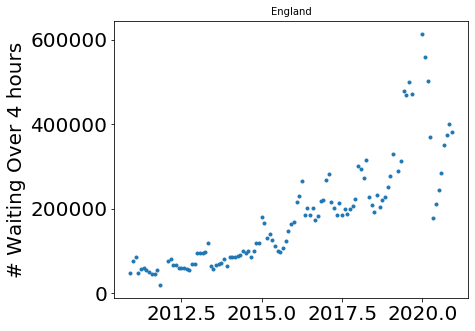

In [11]:
i = 0

fig = plt.figure(figsize=(7,5))

ax1 = fig.add_subplot(111)
plt.title(allNames[i],size = 10)
mask = (final_over4hours[i,:] != '-')
waiting = final_over4hours[i,:][mask]
ax1.plot(months[mask], waiting,'.', lw=3)
ax1.set_ylabel("# Waiting Over 4 hours")
plt.tight_layout()
plt.show()

In [12]:
np.save("NHSwaiting.npy", [allNames, final_periods, final_attendence, final_over4hours])

In [13]:
final_periods[4]

'07/2020'